<a id='top'></a>

# Data Engineering of StatsBomb Data
##### Notebook to engineer a raw JSON data extract of [StatsBomb](https://statsbomb.com/) data downloaded from the API.

### By [Edd Webster](https://www.twitter.com/eddwebster)
Last updated: 10/11/2020

![title](../../img/stats-bomb-logo.png)

![title](../../img/stoke_city_badge_small.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers scraped data for shooting from [StatsBomb](https://statsbomb.com/) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/),
*    edd.j.webster@gmail.com,
*    [@eddwebster](https://www.twitter.com/eddwebster),
*    [LinkedIn.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/),
*    [GitHub/eddwebster](https://github.com/eddwebster/),
*    [Kaggle.com/eddwebster](https://www.kaggle.com/eddwebster), and
*    [HackerRank.com/eddwebster](https://www.hackerrank.com/eddwebster).

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/fifa-league) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/fifa-league/blob/master/FIFA%2020%20Fantasy%20Football%20League%20using%20TransferMarkt%20Player%20Valuations.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    `tqdm` for a clean progress bar;
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd    # version 1.0.3
import os    #  used to read the csv filenames
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
import codecs
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno    # visually display missing data

# Progress Bar
from tqdm import tqdm    # a clean progress bar library

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.1
pandas: 1.0.1
matplotlib: 3.1.3
Seaborn: 0.10.0


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [4]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_fbref = os.path.join(base_dir, 'data', 'fbref')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
data_dir_sb = os.path.join(base_dir, 'data', 'statsbomb')
data_dir_understat = os.path.join(base_dir, 'data', 'understat')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [5]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to engineer football shooting data from [StatsBomb](https://statsbomb.com/), using [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames.

The data of player values produced in this notebook is exported to CSV. This data can be further analysed in Python, joined to other datasets, or explored using Tableau, PowerBI, Microsoft Excel.

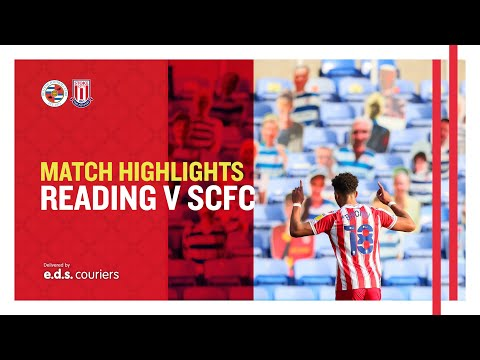

In [6]:
# Stoke City highlights
YouTubeVideo('7PcT3iYKGrg', width=800, height=470)

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
[StatsBomb](https://statsbomb.com/) are a football analytics and data company.

Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and Cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Data Dictionary</a>
The [StatsBomb](https://statsbomb.com/) dataset has one hundred and fourteen features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `id`    | `object`
| `index`    | `object`
| `period`    | `object`
| `timestamp`    | `object`
| `minute`    | `object`
| `second`    | `object`
| `possession`    | `object`
| `duration`    | `object`
| `type.id`    | `object`
| `type.name`    | `object`
| `possession_team.id`    | `object`
| `possession_team.name`    | `object`
| `play_pattern.id`    | `object`
| `play_pattern.name`    | `object`
| `team.id`    | `object`
| `team.name`    | `object`
| `tactics.formation`    | `object`
| `tactics.lineup`    | `object`
| `related_events`    | `object`
| `location`    | `object`
| `player.id`    | `object`
| `player.name`    | `object`
| `position.id`    | `object`
| `position.name`    | `object`
| `pass.recipient.id`    | `object`
| `pass.recipient.name`    | `object`
| `pass.length`    | `object`
| `pass.angle`    | `object`
| `pass.height.id`    | `object`
| `pass.height.name`    | `object`
| `pass.end_location`    | `object`
| `pass.type.id`    | `object`
| `pass.type.name`    | `object`
| `pass.body_part.id`    | `object`
| `pass.body_part.name`    | `object`
| `carry.end_location`    | `object`
| `under_pressure`    | `object`
| `duel.type.id`    | `object`
| `duel.type.name`    | `object`
| `out`    | `object`
| `miscontrol.aerial_won`    | `object`
| `pass.outcome.id`    | `object`
| `pass.outcome.name`    | `object`
| `ball_receipt.outcome.id`    | `object`
| `ball_receipt.outcome.name`    | `object`
| `pass.aerial_won`    | `object`
| `counterpress`    | `object`
| `off_camera`    | `object`
| `dribble.outcome.id`    | `object`
| `dribble.outcome.name`    | `object`
| `dribble.overrun`    | `object`
| `ball_recovery.offensive`    | `object`
| `shot.statsbomb_xg`    | `object`
| `shot.end_location`    | `object`
| `shot.outcome.id`    | `object`
| `shot.outcome.name`    | `object`
| `shot.type.id`    | `object`
| `shot.type.name`    | `object`
| `shot.body_part.id`    | `object`
| `shot.body_part.name`    | `object`
| `shot.technique.id`    | `object`
| `shot.technique.name`    | `object`
| `shot.freeze_frame`    | `object`
| `goalkeeper.end_location`    | `object`
| `goalkeeper.type.id`    | `object`
| `goalkeeper.type.name`    | `object`
| `goalkeeper.position.id`    | `object`
| `goalkeeper.position.name`    | `object`
| `pass.straight`    | `object`
| `pass.technique.id`    | `object`
| `pass.technique.name`    | `object`
| `clearance.head`    | `object`
| `clearance.body_part.id`    | `object`
| `clearance.body_part.name`    | `object`
| `pass.switch`    | `object`
| `duel.outcome.id`    | `object`
| `duel.outcome.name`    | `object`
| `foul_committed.advantage`    | `object`
| `foul_won.advantage`    | `object`
| `pass.cross`    | `object`
| `pass.assisted_shot_id`    | `object`
| `pass.shot_assist`    | `object`
| `shot.one_on_one`    | `object`
| `shot.key_pass_id`    | `object`
| `goalkeeper.body_part.id`    | `object`
| `goalkeeper.body_part.name`    | `object`
| `goalkeeper.technique.id`    | `object`
| `goalkeeper.technique.name`    | `object`
| `goalkeeper.outcome.id`    | `object`
| `goalkeeper.outcome.name`    | `object`
| `clearance.aerial_won`    | `object`
| `foul_committed.card.id`    | `object`
| `foul_committed.card.name`    | `object`
| `foul_won.defensive`    | `object`
| `clearance.right_foot`    | `object`
| `shot.first_time`    | `object`
| `pass.through_ball`    | `object`
| `interception.outcome.id`    | `object`
| `interception.outcome.name`    | `object`
| `clearance.left_foot`    | `object`
| `ball_recovery.recovery_failure`    | `object`
| `shot.aerial_won`    | `object`
| `pass.goal_assist`    | `object`
| `pass.cut_back`    | `object`
| `pass.deflected`    | `object`
| `clearance.other`    | `object`
| `pass.outswinging`    | `object`
| `substitution.outcome.id`    | `object`
| `substitution.outcome.name`    | `object`
| `substitution.replacement.id`    | `object`
| `substitution.replacement.name`    | `object`
| `block.deflection`    | `object`
| `block.offensive`    | `object`
| `injury_stoppage.in_chain`    | `object`

For a full list of definitions, see the official documentation [[link](https://statsbomb.com/stat-definitions/)].

### <a id='#section3.3'>3.3. Creating the DataFrame</a>
The data is an extract of JSON data from the StatsBomb API provided by Stoke City Football Club.

In [7]:
# Show files in directory
print(glob.glob(data_dir_sb + '/raw/*.json'))

['../../data/statsbomb/raw/reading_stoke_07112020.json']


In [8]:
sb_json = json.load(codecs.open(data_dir_sb + '/raw/reading_stoke_07112020.json', 'r', 'utf-8-sig'))

In [9]:
sb_json

[{'id': 'c5337eac-8244-4e2e-b27a-82658e26fc24',
  'index': 1,
  'period': 1,
  'timestamp': '00:00:00.000',
  'minute': 0,
  'second': 0,
  'type': {'id': 35, 'name': 'Starting XI'},
  'possession': 1,
  'possession_team': {'id': 50, 'name': 'Reading'},
  'play_pattern': {'id': 1, 'name': 'Regular Play'},
  'team': {'id': 50, 'name': 'Reading'},
  'duration': 0,
  'tactics': {'formation': 41212,
   'lineup': [{'player': {'id': 22601, 'name': 'Rafael Cabral Barbosa'},
     'position': {'id': 1, 'name': 'Goalkeeper'},
     'jersey_number': 33},
    {'player': {'id': 4580, 'name': 'Andy Yiadom'},
     'position': {'id': 2, 'name': 'Right Back'},
     'jersey_number': 17},
    {'player': {'id': 9480, 'name': 'Michael Morrison'},
     'position': {'id': 3, 'name': 'Right Center Back'},
     'jersey_number': 4},
    {'player': {'id': 28105, 'name': 'Lewis Jack Gibson'},
     'position': {'id': 5, 'name': 'Left Center Back'},
     'jersey_number': 15},
    {'player': {'id': 9537, 'name': 'Oma

In [10]:
df_raw = pd.json_normalize(sb_json)

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
df_raw.head(10)

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain
0,c5337eac-8244-4e2e-b27a-82658e26fc24,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,50,Reading,1,Regular Play,50,Reading,41212.0,"[{'player': {'id': 22601, 'name': 'Rafael Cabr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ad10ed74-eda9-4522-9cba-8096c69363df,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,50,Reading,1,Regular Play,30,Stoke City,442.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,717f5a10-f3cf-44f3-899e-a272b50e41b0,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,50,Reading,1,Regular Play,30,Stoke City,NaN,NaN,[71ba05ee-fd6d-43c0-ac62-12b14d01fb5c],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71ba05ee-fd6d-43c0-ac62-12b14d01fb5c,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,50,Reading,1,Regular Play,50,Reading,NaN,NaN,[717f5a10-f3cf-44f3-899e-a272b50e41b0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### <a id='#section3.4'>3.4. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [13]:
# Display the first 5 rows of the raw DataFrame, df_raw
df_raw.head()

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain
0,c5337eac-8244-4e2e-b27a-82658e26fc24,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,50,Reading,1,Regular Play,50,Reading,41212.0,"[{'player': {'id': 22601, 'name': 'Rafael Cabr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ad10ed74-eda9-4522-9cba-8096c69363df,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,50,Reading,1,Regular Play,30,Stoke City,442.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,717f5a10-f3cf-44f3-899e-a272b50e41b0,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,50,Reading,1,Regular Play,30,Stoke City,NaN,NaN,[71ba05ee-fd6d-43c0-ac62-12b14d01fb5c],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71ba05ee-fd6d-43c0-ac62-12b14d01fb5c,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,50,Reading,1,Regular Play,50,Reading,NaN,NaN,[717f5a10-f3cf-44f3-899e-a272b50e41b0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [14]:
# Display the last 5 rows of the raw DataFrame, df_raw
df_raw.tail()

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain
3377,435762be-4731-4068-a5f7-9c6cfd058c4b,3378,2,00:49:37.850,94,37,165,0.93075,16,Shot,30,Stoke City,6,From Counter,30,Stoke City,NaN,NaN,[423928d6-a7b1-4297-a43f-974243bc05e6],"[104.6, 46.9, 0]",12197.0,Jacob Brown,23.0,Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.802039,"[120, 42, 0]",97.0,Goal,87.0,Open Play,40.0,Right Foot,93.0,Normal,"[{'location': [111.9, 37], 'player': {'id': 28...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3378,423928d6-a7b1-4297-a43f-974243bc05e6,3379,2,00:49:38.781,94,38,165,0.00000,23,Goal Keeper,30,Stoke City,1,Regular Play,50,Reading,NaN,NaN,[435762be-4731-4068-a5f7-9c6cfd058c4b],"[17.3, 45.8]",22601.0,Rafael Cabral Barbosa,1.0,Goalkeeper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,Goal Conceded,42.0,Moving,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,Standing,55.0,No Touch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3379,e8face51-d1f4-4aea-8d23-c296a340b549,3380,2,00:50:42.135,95,42,165,0.00000,40,Injury Stoppage,30,Stoke City,1,Regular Play,30,Stoke City,NaN,NaN,NaN,NaN,22379.0,Angus Gunn,1.0,Goalkeeper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3380,29afd7b0-b0b8-4367-9321-0c77339e2df7,3381,2,00:50:46.544,95,46,165,0.00000,34,Half End,30,Stoke City,1,Regular Play,30,Stoke City,NaN,NaN,[01e57

In [15]:
df_raw.shape

(3382, 114)

The datasets have twenty features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [16]:
# Display all column names
list(df_raw.columns)

['id',
 'index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'duration',
 'type.id',
 'type.name',
 'possession_team.id',
 'possession_team.name',
 'play_pattern.id',
 'play_pattern.name',
 'team.id',
 'team.name',
 'tactics.formation',
 'tactics.lineup',
 'related_events',
 'location',
 'player.id',
 'player.name',
 'position.id',
 'position.name',
 'pass.recipient.id',
 'pass.recipient.name',
 'pass.length',
 'pass.angle',
 'pass.height.id',
 'pass.height.name',
 'pass.end_location',
 'pass.type.id',
 'pass.type.name',
 'pass.body_part.id',
 'pass.body_part.name',
 'carry.end_location',
 'under_pressure',
 'duel.type.id',
 'duel.type.name',
 'out',
 'miscontrol.aerial_won',
 'pass.outcome.id',
 'pass.outcome.name',
 'ball_receipt.outcome.id',
 'ball_receipt.outcome.name',
 'pass.aerial_won',
 'counterpress',
 'off_camera',
 'dribble.outcome.id',
 'dribble.outcome.name',
 'dribble.overrun',
 'ball_recovery.offensive',
 'shot.statsbomb_xg',
 'shot.end_location',
 'sh

In [17]:
# Data types of the features of the raw DataFrame, df_raw
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_raw.dtypes)

id                                 object
index                               int64
period                              int64
timestamp                          object
minute                              int64
second                              int64
possession                          int64
duration                          float64
type.id                             int64
type.name                          object
possession_team.id                  int64
possession_team.name               object
play_pattern.id                     int64
play_pattern.name                  object
team.id                             int64
team.name                          object
tactics.formation                 float64
tactics.lineup                     object
related_events                     object
location                           object
player.id                         float64
player.name                        object
position.id                       float64
position.name                     

Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [18]:
# Info for the raw DataFrame, df_raw
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Columns: 114 entries, id to injury_stoppage.in_chain
dtypes: float64(31), int64(9), object(74)
memory usage: 2.9+ MB


In [19]:
# Description of the raw DataFrame, df_raw, showing some summary statistics for each numberical column in the DataFrame
df_raw.describe()

,index,period,minute,second,possession,duration,type.id,possession_team.id,play_pattern.id,team.id,tactics.formation,player.id,position.id,pass.recipient.id,pass.length,pass.angle,pass.height.id,pass.type.id,pass.body_part.id,duel.type.id,pass.outcome.id,ball_receipt.outcome.id,dribble.outcome.id,shot.statsbomb_xg,shot.outcome.id,shot.type.id,shot.body_part.id,shot.technique.id,goalkeeper.type.id,goalkeeper.position.id,pass.technique.id,clearance.body_part.id,duel.outcome.id,goalkeeper.body_part.id,goalkeeper.technique.id,goalkeeper.outcome.id,foul_committed.card.id,interception.outcome.id,substitution.outcome.id,substitution.replacement.id
count,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,2495.000000,3382.000000,3382.000000,3382.000000,3382.000000,5.000000,3367.000000,3367.000000,887.000000,965.000000,965.000000,965.000000,228.000000,879.000000,85.000000,231.000000,153.0,37.000000,25.000000,25.000000,25.0,25.000000,25.000000,25.000000,25.00,9.000000,42.000000,31.000000,4.000000,7.000000,7.000000,2.0,6.000000,6.000000,6.000000
mean,1691.500000,1.497635,45.289178,29.122117,82.659669,1.384913,32.324069,44.311059,2.889415,42.625665,17345.800000,12915.354618,10.561331,12701.441939,24.040324,0.061888,1.718135,65.350877,39.621160,10.364706,17.311688,9.0,8.459459,0.098272,97.720000,87.0,38.520000,92.840000,31.440000,43.92,106.666667,38.428571,11.645161,38.000000,45.857143,43.714286,7.0,9.000000,102.833333,18744.500000
std,976.443632,0.500068,27.283461,17.274722,46.391915,1.569880,12.082689,9.024348,2.054611,9.650566,21820.678088,9546.022476,7.379193,9364.382427,16.630790,1.571885,0.889853,1.745895,4.094116,0.484204,21.985129,0.0,0.505228,0.171208,1.568439,0.0,1.294862,0.553775,2.083267,0.40,1.000000,5.114031,5.468384,3.464102,0.377964,19.720668,0.0,5.585696,0.408248,11939.772473
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,30.000000,1.000000,30.000000,442.000000,3298.000000,1.000000,3298.000000,1.044031,-3.133154,1.000000,61.000000,37.000000,10.000000,9.000000,9.0,8.000000,0.014009,96.000000,87.0,37.000000,91.000000,26.000000,42.00,105.000000,37.000000,4.000000,35.000000,45.000000,15.000000,7.0,4.000000,102.000000,4890.000000
25%,846.250000,1.000000,20.000000,14.000000,40.000000,0.387013,30.000000,30.000000,1.000000,30.000000,442.000000,4725.000000,3.000000,4725.000000,12.244999,-1.119968,1.000000,66.000000,38.000000,10.000000,9.000000,9.0,8.000000,0.021805,96.000000,87.0,37.000000,93.000000,32.000000,44.00,107.000000,37.000000,4.000000,35.000000,46.000000,33.500000,7.0,4.000000,103.000000,10199.750000
50%,1691.500000,1.000000,45.000000,29.000000,80.000000,1.119648,30.000000,50.000000,3.000000,50.000000,3421.000000,9537.000000,10.000000,9537.000000,19.401031,0.000000,1.000000,66.000000,40.000000,10.000000,9.000000,9.0,8.000000,0.035960,98.000000,87.0,38.000000,93.000000,32.000000,44.00,107.000000,37.000000,14.000000,38.000000,46.000000,55.000000,7.0,8.500000,103.000000,18206.000000
75%,2536.750000,2.000000,68.000000,44.000000,122.000000,1.872663,42.000000,50.000000,4.000000,50.000000,41212.000000,20674.000000,16.000000,16793.000000,30.805843,1.343107,3.000000,66.000000,40.000000,11.000000,9.000000,9.0,9.000000,0.057166,98.000000,87.0,40.000000,93.000000,32.000000,44.00,107.000000,38.000000,16.000000,41.000000,46.000000,55.000000,7.0,13.000000,103.000000,24671.750000
max,3382.000000,2.000000,95.000000,59.000000,165.000000,26.251377,43.000000,50.000000,9.000000,50.000000,41212.000000,38858.000000,24.000000,38858.000000,105.627740,3.141593,3.000000,67.000000,70.000000,11.000000,77.000000,9.0,9.000000,0.802039,101.000000,87.0,40.000000,93.000000,33.000000,44.00,108.000000,70.000000,17.000000,41.000000,46.000000,59.000000,7.0,16.000000,103.000000,36807.000000


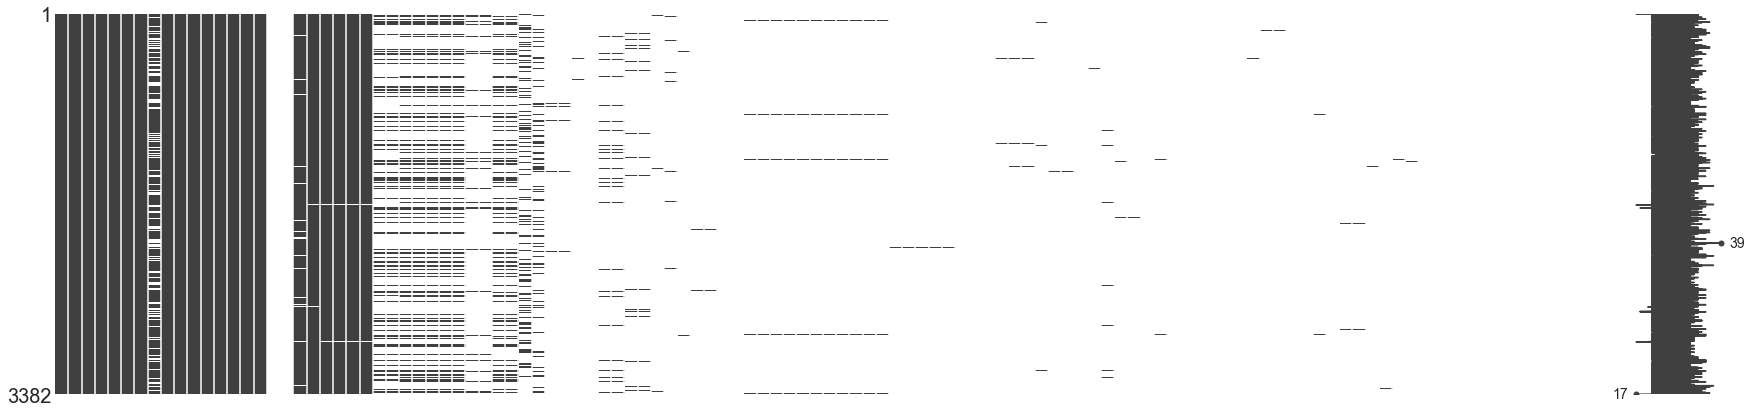

In [20]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_raw
msno.matrix(df_raw, figsize = (30, 7))

In [21]:
# Counts of missing values
tm_null_value_stats = df_raw.isnull().sum(axis=0)
tm_null_value_stats[tm_null_value_stats != 0]

duration                          887
tactics.formation                3377
tactics.lineup                   3377
related_events                    129
location                           25
                                 ... 
substitution.replacement.id      3376
substitution.replacement.name    3376
block.deflection                 3381
block.offensive                  3380
injury_stoppage.in_chain         3381
Length: 99, dtype: int64

The visualisation shows us very quickly that there are many columns with missing values.

### <a id='#section3.5'>3.5. Export Data</a>
Export the data in CSV format.

In [22]:
# Export the raw DataFrame
df_raw.to_csv(data_dir_sb + '/raw/reading_stoke_07112020.csv', index=None, header=True)

The next stage is to engineer the dataset.

## <a id='#section4'>4. Data Engineering</a>

### <a id='#section4.1'>4.1. Introduction</a>
Before conducting an [Exploratory Data Analysis (EDA)](#section5) of the data, we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.2'>4.2. Break down `location` attributes into seperate attribute for X, Y (and sometimes Z) coordinates</a>

In [23]:
df_raw.head(10)

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain
0,c5337eac-8244-4e2e-b27a-82658e26fc24,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,50,Reading,1,Regular Play,50,Reading,41212.0,"[{'player': {'id': 22601, 'name': 'Rafael Cabr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ad10ed74-eda9-4522-9cba-8096c69363df,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,50,Reading,1,Regular Play,30,Stoke City,442.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,717f5a10-f3cf-44f3-899e-a272b50e41b0,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,50,Reading,1,Regular Play,30,Stoke City,NaN,NaN,[71ba05ee-fd6d-43c0-ac62-12b14d01fb5c],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71ba05ee-fd6d-43c0-ac62-12b14d01fb5c,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,50,Reading,1,Regular Play,50,Reading,NaN,NaN,[717f5a10-f3cf-44f3-899e-a272b50e41b0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [24]:
# Display all location columns
for col in df_raw.columns:
    if 'location' in col:
        print(col)

location
pass.end_location
carry.end_location
shot.end_location
goalkeeper.end_location


There are the following five 'location' attributes:
- `location`
- `pass.end_location`
- `carry.end_location`
- `shot.end_location`
- `goalkeeper.end_location`

From reviewing the official documentation [[link](https://statsbomb.com/stat-definitions/)], the five attributes have the following dimensionality:
- `location` [x, y, z]
- `pass.end_location` [x, y]
- `carry.end_location` [x, y]
- `shot.end_location` [x, y, z]
- `goalkeeper.end_location` [x, y]

In [25]:
# 

## Break down each location attributes

### Location
df_location = df_raw['location'].apply(pd.Series)
df_location.columns = ['location_x', 'location_y', 'location_z']

### Pass End Location
df_pass_end_location = df_raw['pass.end_location'].apply(pd.Series)
df_pass_end_location.columns = ['pass.end_location_x', 'pass.end_location_y']

### Carry End Location
df_carry_end_location = df_raw['carry.end_location'].apply(pd.Series)
df_carry_end_location.columns = ['carry.end_location_x', 'carry.end_location_y']

### Shot End Location
df_shot_end_location = df_raw['shot.end_location'].apply(pd.Series)
df_shot_end_location.columns = ['shot.end_location_x', 'shot.end_location_y', 'shot.end_location_z']

### Goalkeeper End Location
df_goalkeeper_end_location = df_raw['goalkeeper.end_location'].apply(pd.Series)
df_goalkeeper_end_location.columns = ['goalkeeper.end_location_x', 'goalkeeper.end_location_y']


## Join seperated location DataFrames back to the original df_raw StatsBomb Event data DataFrame
df_raw = pd.merge(df_raw, df_location, left_index=True, right_index=True)
df_raw = pd.merge(df_raw, df_pass_end_location, left_index=True, right_index=True)
df_raw = pd.merge(df_raw, df_carry_end_location, left_index=True, right_index=True)
df_raw = pd.merge(df_raw, df_shot_end_location, left_index=True, right_index=True)
df_raw = pd.merge(df_raw, df_goalkeeper_end_location, left_index=True, right_index=True)

##
df_raw.head()

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain,location_x,location_y,location_z,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
0,c5337eac-8244-4e2e-b27a-82658e26fc24,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,50,Reading,1,Regular Play,50,Reading,41212.0,"[{'player': {'id': 22601, 'name': 'Rafael Cabr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ad10ed74-eda9-4522-9cba-8096c69363df,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,50,Reading,1,Regular Play,30,Stoke City,442.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,717f5a10-f3cf-44f3-899e-a272b50e41b0,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,50,Reading,1,Regular Play,30,Stoke City,NaN,NaN,[71ba05ee-fd6d-43c0-ac62-12b14d01fb5c],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### <a id='#section4.3'>4.3. Extract Lineups from DataFrame</a>

In [26]:
# List unique values in the df_raw['type.name'] column
df_raw['type.name'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Duel', 'Miscontrol', 'Pressure', 'Ball Recovery', 'Dribbled Past',
       'Dribble', 'Shot', 'Block', 'Goal Keeper', 'Clearance',
       'Dispossessed', 'Foul Committed', 'Foul Won', 'Interception',
       'Shield', 'Half End', 'Substitution', 'Tactical Shift',
       'Injury Stoppage', 'Player Off', 'Player On', 'Offside',
       'Referee Ball-Drop', 'Error'], dtype=object)

The starting XI players and formation can be found in the rows where `type.name` is 'Starting XI'.

In [27]:
df_lineup = df_raw[df_raw['type.name'] == 'Starting XI']

In [28]:
df_lineup

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain,location_x,location_y,location_z,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
0,c5337eac-8244-4e2e-b27a-82658e26fc24,1,1,00:00:00.000,0,0,1,0.0,35,Starting XI,50,Reading,1,Regular Play,50,Reading,41212.0,"[{'player': {'id': 22601, 'name': 'Rafael Cabr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ad10ed74-eda9-4522-9cba-8096c69363df,2,1,00:00:00.000,0,0,1,0.0,35,Starting XI,50,Reading,1,Regular Play,30,Stoke City,442.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Streamline DataFrame to include just the columns of interest

## Define columns
cols = ['id', 'type.name', 'team.id', 'team.name', 'tactics.formation', 'tactics.lineup']

## Select only columns of interest
df_lineup_select = df_lineup[cols]

In [30]:
df_lineup_select

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup
0,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,"[{'player': {'id': 22601, 'name': 'Rafael Cabr..."
1,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'..."


We can see from the extracted lineup data so far, Reading started with a 4-1-2-1-2 formation and Stoke City started with a 4-4-2 formation. Michael O'Neill however says Stoke City started with a 3-4-3 formation [[link](https://www.youtube.com/watch?v=jy1zHNHp8LI&ab_channel=StokeCityFC)].

To get the stating XI players, we need to breakdown the `tactics.lineup` attribute.

In [31]:
# Normalize tactics.lineup - see: https://stackoverflow.com/questions/52795561/flattening-nested-json-in-pandas-data-frame

## explode all columns with lists of dicts
df_lineup_select_normalize = df_lineup_select.apply(lambda x: x.explode()).reset_index(drop=True)

## list of columns with dicts
cols_to_normalize = ['tactics.lineup']

## if there are keys, which will become column names, overlap with excising column names. add the current column name as a prefix
normalized = list()
for col in cols_to_normalize:
    
    d = pd.json_normalize(df_lineup_select_normalize[col], sep='_')
    d.columns = [f'{col}_{v}' for v in d.columns]
    normalized.append(d.copy())

## combine df with the normalized columns
df_lineup_select_normalize = pd.concat([df_lineup_select_normalize] + normalized, axis=1).drop(columns=cols_to_normalize)

## display(df_lineup_select_normalize)
df_lineup_select_normalize.head(10)

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup_jersey_number,tactics.lineup_player_id,tactics.lineup_player_name,tactics.lineup_position_id,tactics.lineup_position_name
0,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,33,22601,Rafael Cabral Barbosa,1,Goalkeeper
1,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,17,4580,Andy Yiadom,2,Right Back
2,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,4,9480,Michael Morrison,3,Right Center Back
3,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,15,28105,Lewis Jack Gibson,5,Left Center Back
4,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,3,9537,Omar Richards,6,Left Back
5,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,8,16793,Andrew Ferai Rinomhota,10,Center Defensive Midfield
6,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,2,38858,Tomás Lago Pontes Esteves,13,Right Center Midfield
7,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,28,3954,Josh Laurent,15,Left Center Midfield
8,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,30,10323,Alfa Semedo Esteves,19,Center Attacking Midfield
9,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,47,8660,George Alexandru Puşcaş,22,Right Center Forward


In [32]:
df_lineup_reading = df_lineup_select_normalize[df_lineup_select_normalize['team.name'] == 'Reading']
df_lineup_stoke = df_lineup_select_normalize[df_lineup_select_normalize['team.name'] == 'Stoke City']

In [33]:
df_lineup_reading

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup_jersey_number,tactics.lineup_player_id,tactics.lineup_player_name,tactics.lineup_position_id,tactics.lineup_position_name
0,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,33,22601,Rafael Cabral Barbosa,1,Goalkeeper
1,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,17,4580,Andy Yiadom,2,Right Back
2,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,4,9480,Michael Morrison,3,Right Center Back
3,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,15,28105,Lewis Jack Gibson,5,Left Center Back
4,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,3,9537,Omar Richards,6,Left Back
5,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,8,16793,Andrew Ferai Rinomhota,10,Center Defensive Midfield
6,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,2,38858,Tomás Lago Pontes Esteves,13,Right Center Midfield
7,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,28,3954,Josh Laurent,15,Left Center Midfield
8,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,30,10323,Alfa Semedo Esteves,19,Center Attacking Midfield
9,c5337eac-8244-4e2e-b27a-82658e26fc24,Starting XI,50,Reading,41212.0,47,8660,George Alexandru Puşcaş,22,Right Center Forward


In [34]:
df_lineup_stoke

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup_jersey_number,tactics.lineup_player_id,tactics.lineup_player_name,tactics.lineup_position_id,tactics.lineup_position_name
11,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,1,22379,Angus Gunn,1,Goalkeeper
12,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,14,3298,Tom Smith,2,Right Back
13,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,36,22293,Harry Souttar,3,Right Center Back
14,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,6,20674,Danny Batth,5,Left Center Back
15,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,3,10491,Morgan Fox,6,Left Back
16,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,13,5475,John Michael Nchekwube Obinna,9,Right Defensive Midfield
17,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,34,9497,Jordan Thompson,11,Left Defensive Midfield
18,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,26,4725,Tyrese Campbell,12,Right Midfield
19,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,11,3514,James McClean,16,Left Midfield
20,ad10ed74-eda9-4522-9cba-8096c69363df,Starting XI,30,Stoke City,442.0,21,9554,Steven Fletcher,22,Right Center Forward


In [35]:
#

##
lst_frames_lineup = [df_lineup_reading, df_lineup_stoke]

##
df_lineup_combined = pd.concat(lst_frames_lineup)

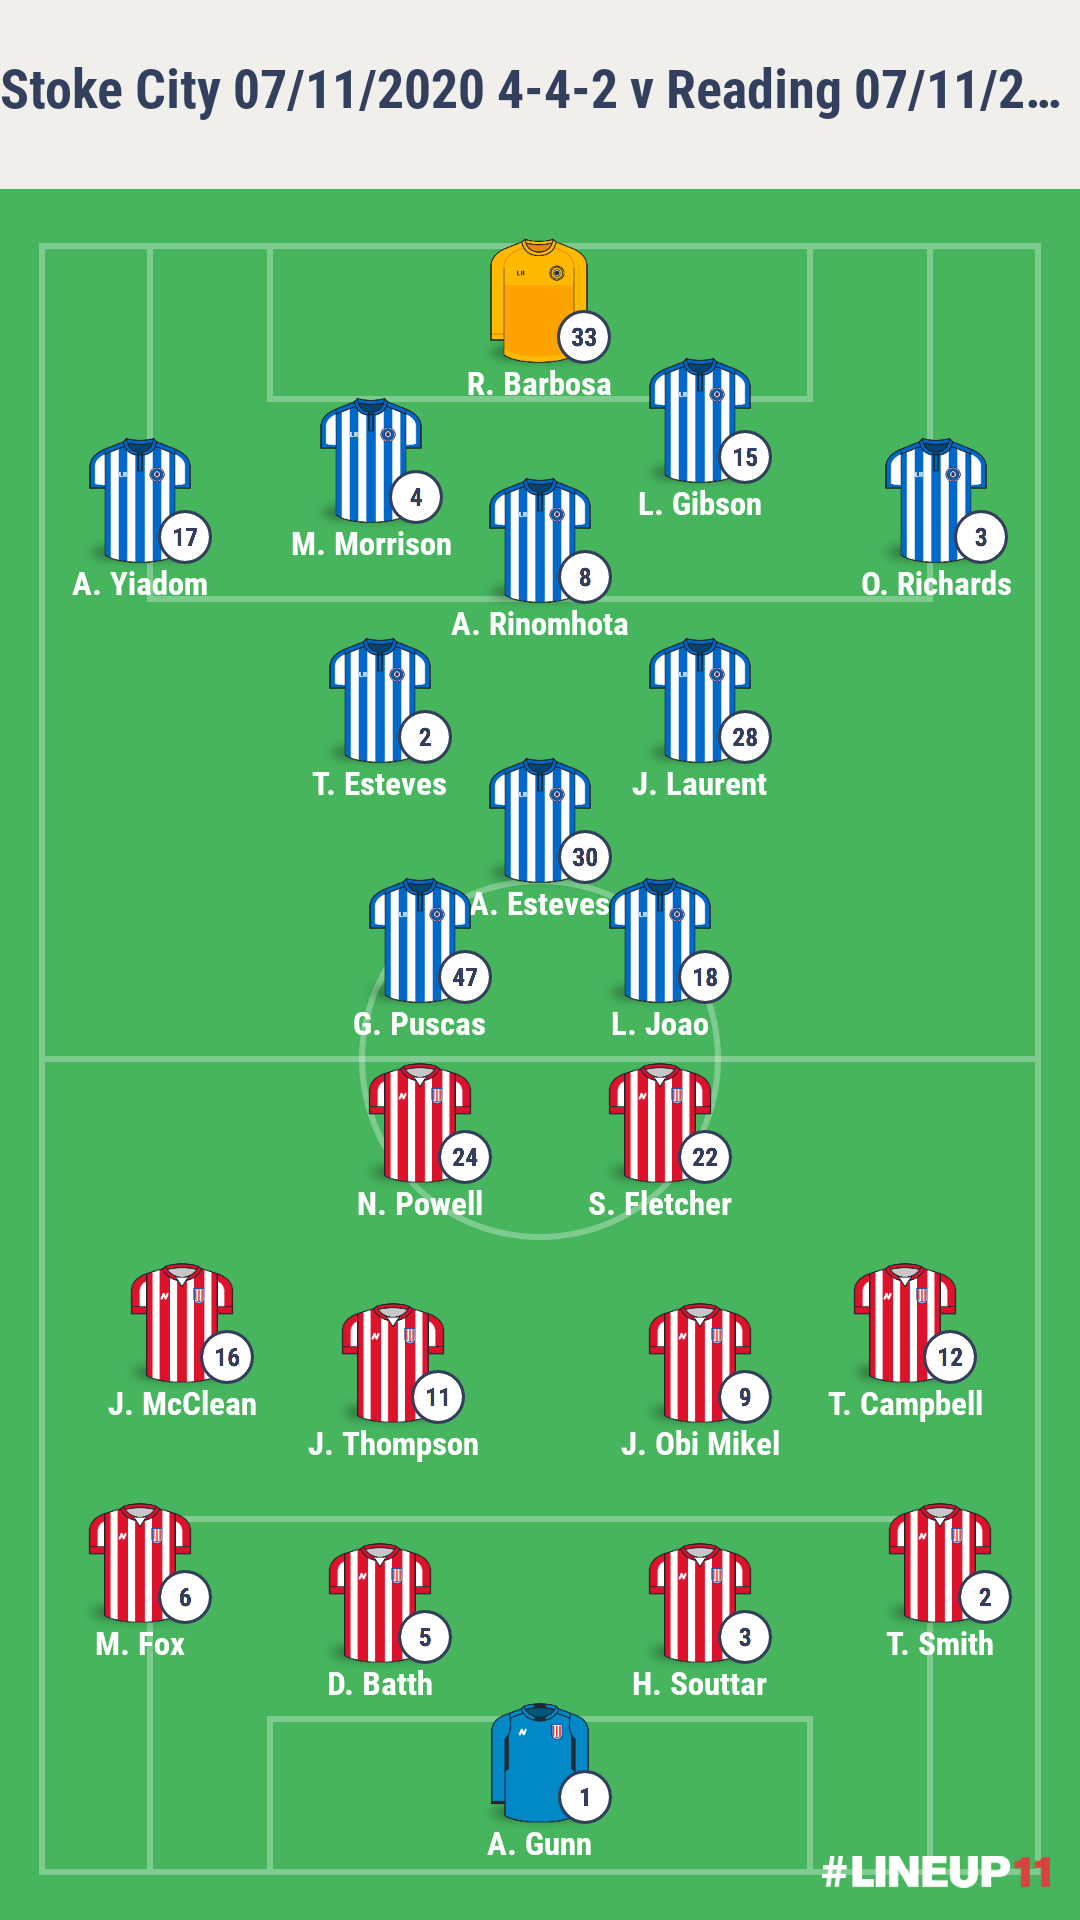

In [36]:
Image('../../img/stoke_city_reading_07112020.png', width=500)

### <a id='#section4.4'>4.4. Tactical Shifts</a>

In [37]:
df_tactics = df_raw[df_raw['type.name'] == 'Tactical Shift']

In [38]:
df_tactics

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain,location_x,location_y,location_z,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
1725,ca6d98ef-df2b-4ddc-9865-108d796b844b,1726,2,00:00:57.257,45,57,82,0.0,36,Tactical Shift,50,Reading,9,From Kick Off,30,Stoke City,442.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2645,813ac310-b71b-452e-8b95-a217aa1d4aae,2646,2,00:27:48.466,72,48,127,0.0,36,Tactical Shift,50,Reading,1,Regular Play,30,Stoke City,3421.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2647,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,2648,2,00:28:30.176,73,30,127,0.0,36,Tactical Shift,50,Reading,1,Regular Play,50,Reading,41212.0,"[{'player': {'id': 22601, 'name': 'Rafael Cabr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [39]:
# Select columns of interest

##
cols = ['id', 'type.name', 'team.id', 'team.name', 'tactics.formation', 'tactics.lineup']

##
df_tactics_select = df_tactics[cols]

In [40]:
df_tactics_select

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup
1725,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'..."
2645,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,"[{'player': {'id': 22379, 'name': 'Angus Gunn'..."
2647,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,"[{'player': {'id': 22601, 'name': 'Rafael Cabr..."


In [41]:
# Normalize tactics.lineup - see: https://stackoverflow.com/questions/52795561/flattening-nested-json-in-pandas-data-frame

## explode all columns with lists of dicts
df_tactics_select_normalize = df_tactics_select.apply(lambda x: x.explode()).reset_index(drop=True)

## list of columns with dicts
cols_to_normalize = ['tactics.lineup']

## if there are keys, which will become column names, overlap with excising column names. add the current column name as a prefix
normalized = list()
for col in cols_to_normalize:
    
    d = pd.json_normalize(df_tactics_select_normalize[col], sep='_')
    d.columns = [f'{col}_{v}' for v in d.columns]
    normalized.append(d.copy())

## combine df with the normalized columns
df_tactics_select_normalize = pd.concat([df_tactics_select_normalize] + normalized, axis=1).drop(columns=cols_to_normalize)

## display(df_lineup_select_normalize)
df_tactics_select_normalize.head(10)

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup_jersey_number,tactics.lineup_player_id,tactics.lineup_player_name,tactics.lineup_position_id,tactics.lineup_position_name
0,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,1,22379,Angus Gunn,1,Goalkeeper
1,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,14,3298,Tom Smith,2,Right Back
2,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,36,22293,Harry Souttar,3,Right Center Back
3,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,6,20674,Danny Batth,5,Left Center Back
4,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,3,10491,Morgan Fox,6,Left Back
5,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,13,5475,John Michael Nchekwube Obinna,9,Right Defensive Midfield
6,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,34,9497,Jordan Thompson,11,Left Defensive Midfield
7,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,20,36807,Tashan Oakley-Boothe,12,Right Midfield
8,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,11,3514,James McClean,16,Left Midfield
9,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,21,9554,Steven Fletcher,22,Right Center Forward


In [42]:
df_tactics_change1 = df_tactics_select_normalize[df_tactics_select_normalize['id'] == 'ca6d98ef-df2b-4ddc-9865-108d796b844b']
df_tactics_change2 = df_tactics_select_normalize[df_tactics_select_normalize['id'] == '813ac310-b71b-452e-8b95-a217aa1d4aae']
df_tactics_change3 = df_tactics_select_normalize[df_tactics_select_normalize['id'] == 'a3d7e70b-70e5-4ca8-a0ae-985d643eb98e']

In [43]:
df_tactics_change1

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup_jersey_number,tactics.lineup_player_id,tactics.lineup_player_name,tactics.lineup_position_id,tactics.lineup_position_name
0,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,1,22379,Angus Gunn,1,Goalkeeper
1,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,14,3298,Tom Smith,2,Right Back
2,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,36,22293,Harry Souttar,3,Right Center Back
3,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,6,20674,Danny Batth,5,Left Center Back
4,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,3,10491,Morgan Fox,6,Left Back
5,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,13,5475,John Michael Nchekwube Obinna,9,Right Defensive Midfield
6,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,34,9497,Jordan Thompson,11,Left Defensive Midfield
7,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,20,36807,Tashan Oakley-Boothe,12,Right Midfield
8,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,11,3514,James McClean,16,Left Midfield
9,ca6d98ef-df2b-4ddc-9865-108d796b844b,Tactical Shift,30,Stoke City,442.0,21,9554,Steven Fletcher,22,Right Center Forward


In [44]:
df_tactics_change2

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup_jersey_number,tactics.lineup_player_id,tactics.lineup_player_name,tactics.lineup_position_id,tactics.lineup_position_name
11,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,1,22379,Angus Gunn,1,Goalkeeper
12,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,36,22293,Harry Souttar,3,Right Center Back
13,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,6,20674,Danny Batth,4,Center Back
14,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,37,24824,Nathan Michael Collins,5,Left Center Back
15,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,14,3298,Tom Smith,7,Right Wing Back
16,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,3,10491,Morgan Fox,8,Left Wing Back
17,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,13,5475,John Michael Nchekwube Obinna,9,Right Defensive Midfield
18,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,34,9497,Jordan Thompson,11,Left Defensive Midfield
19,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,20,36807,Tashan Oakley-Boothe,18,Right Attacking Midfield
20,813ac310-b71b-452e-8b95-a217aa1d4aae,Tactical Shift,30,Stoke City,3421.0,11,3514,James McClean,20,Left Attacking Midfield


In [45]:
df_tactics_change3

,id,type.name,team.id,team.name,tactics.formation,tactics.lineup_jersey_number,tactics.lineup_player_id,tactics.lineup_player_name,tactics.lineup_position_id,tactics.lineup_position_name
22,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,33,22601,Rafael Cabral Barbosa,1,Goalkeeper
23,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,8,16793,Andrew Ferai Rinomhota,2,Right Back
24,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,4,9480,Michael Morrison,3,Right Center Back
25,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,15,28105,Lewis Jack Gibson,5,Left Center Back
26,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,3,9537,Omar Richards,6,Left Back
27,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,28,3954,Josh Laurent,10,Center Defensive Midfield
28,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,24,9534,Omatsone Folarin Aluko,13,Right Center Midfield
29,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,7,24215,Michael Olise,15,Left Center Midfield
30,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,30,10323,Alfa Semedo Esteves,19,Center Attacking Midfield
31,a3d7e70b-70e5-4ca8-a0ae-985d643eb98e,Tactical Shift,50,Reading,41212.0,9,4890,Sam Baldock,22,Right Center Forward


In [46]:
#

##
lst_frames_tactics = [df_tactics_change1, df_tactics_change2, df_tactics_change3]

##
df_tactics_combined = pd.concat(lst_frames_tactics)

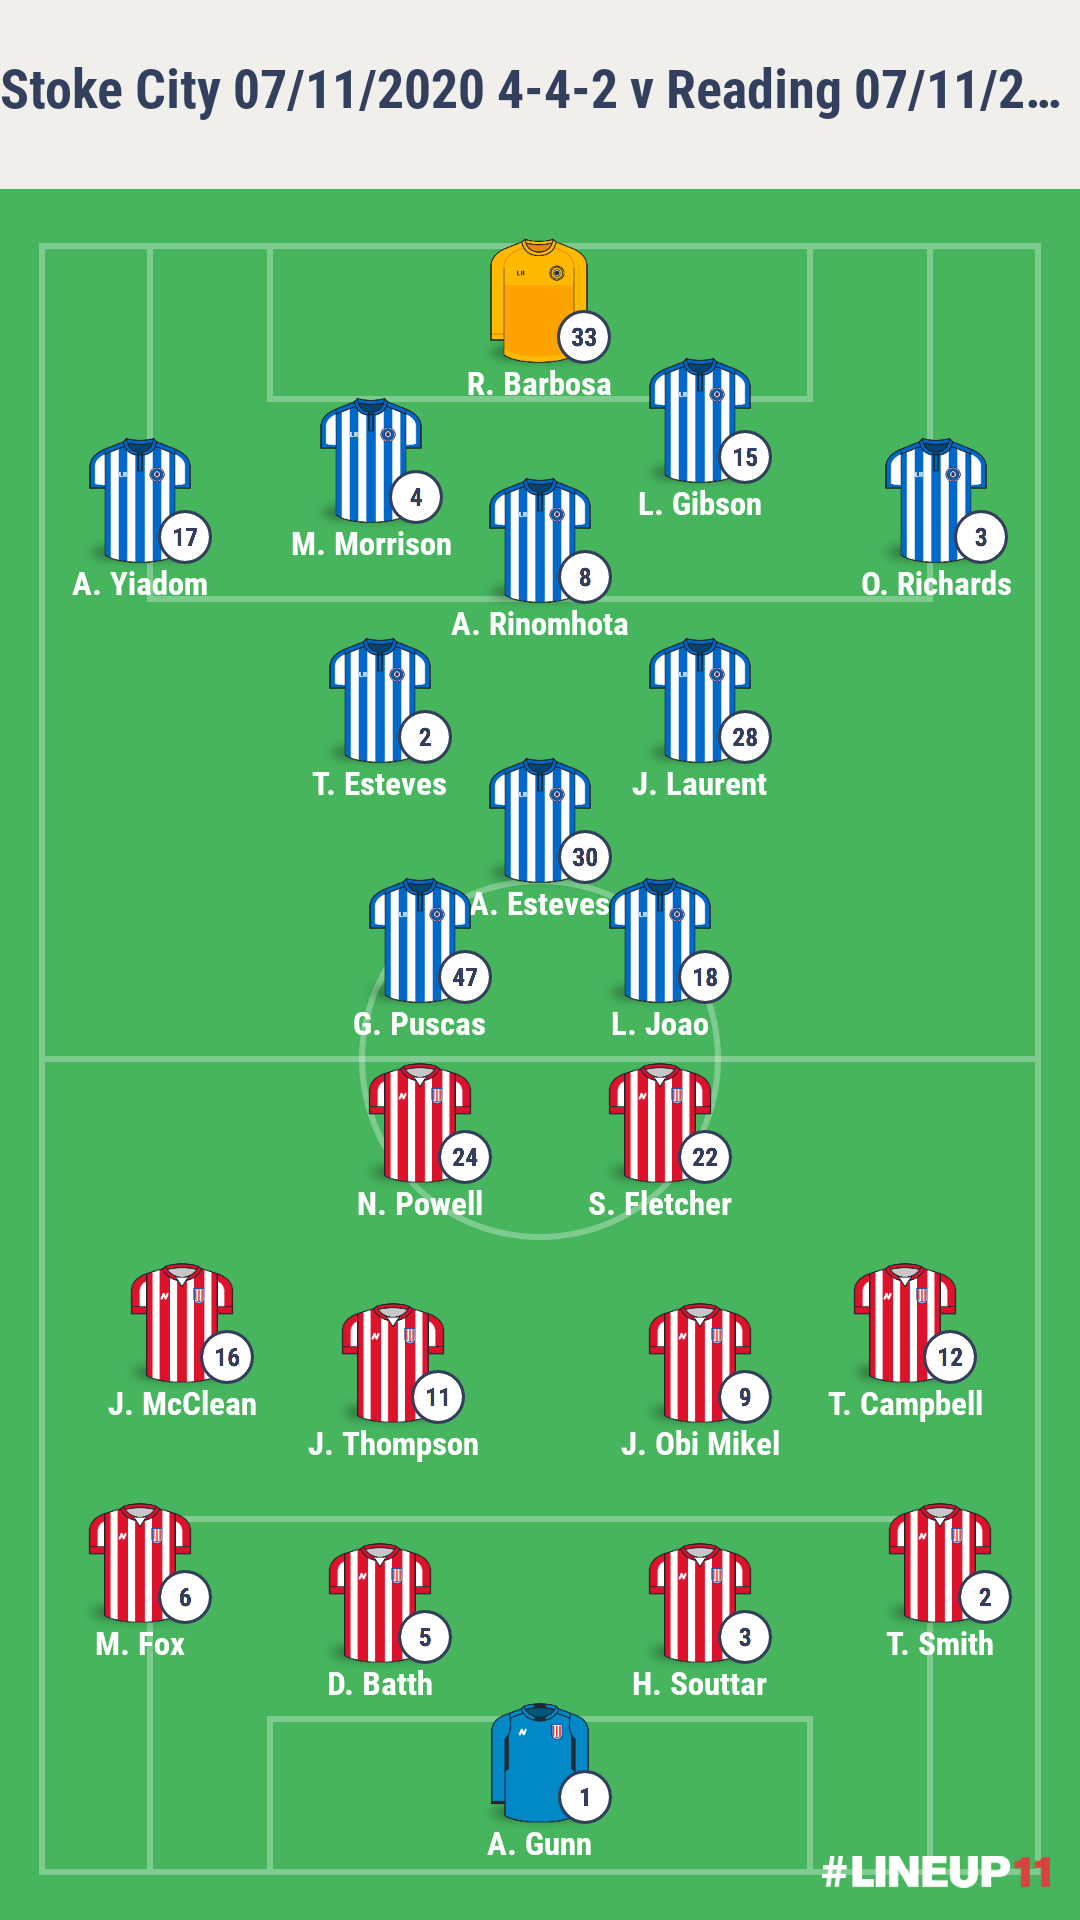

In [47]:
Image('../../img/stoke_city_reading_07112020.png', width=500)    # change this for the XIs at 90 mins

### <a id='#section4.5'>4.5. Halves</a>

In [48]:
df_half = df_raw[df_raw['type.name'] == 'Half Start']

In [49]:
df_half

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain,location_x,location_y,location_z,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
2,717f5a10-f3cf-44f3-899e-a272b50e41b0,3,1,00:00:00.000,0,0,1,0.0,18,Half Start,50,Reading,1,Regular Play,30,Stoke City,NaN,NaN,[71ba05ee-fd6d-43c0-ac62-12b14d01fb5c],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71ba05ee-fd6d-43c0-ac62-12b14d01fb5c,4,1,00:00:00.000,0,0,1,0.0,18,Half Start,50,Reading,1,Regular Play,50,Reading,NaN,NaN,[717f5a10-f3cf-44f3-899e-a272b50e41b0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1699,fce9cac1-e4c4-431a-8b71-cb701fdc2b58,1700,2,00:00:00.000,45,0,81,0.0,18,Half Start,50,Reading,2,From Corner,50,Reading,NaN,NaN,[4e73f010-1be3-49ca-b381-80cc15a14b1c],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### <a id='#section4.5'>4.5. Extract a DataFrame only of In-Play Events</a>
DataFrame of only player's actions i.e. removing line ups, halves, etc.

In [50]:
# List unique values in the df_raw['type.name'] column
df_raw['type.name'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Duel', 'Miscontrol', 'Pressure', 'Ball Recovery', 'Dribbled Past',
       'Dribble', 'Shot', 'Block', 'Goal Keeper', 'Clearance',
       'Dispossessed', 'Foul Committed', 'Foul Won', 'Interception',
       'Shield', 'Half End', 'Substitution', 'Tactical Shift',
       'Injury Stoppage', 'Player Off', 'Player On', 'Offside',
       'Referee Ball-Drop', 'Error'], dtype=object)

In [51]:
lst_events = ['Pass', 'Ball Receipt*', 'Carry', 'Duel', 'Miscontrol', 'Pressure', 'Ball Recovery', 'Dribbled Past', 'Dribble', 'Shot', 'Block', 'Goal Keeper', 'Clearance', 'Dispossessed', 'Foul Committed', 'Foul Won', 'Interception', 'Shield', 'Half End', 'Substitution', 'Tactical Shift', 'Injury Stoppage', 'Player Off', 'Player On', 'Offside', 'Referee Ball-Drop', 'Error']

In [52]:
df_events = df_raw[df_raw['type.name'].isin(lst_events)]

In [53]:
df_events

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain,location_x,location_y,location_z,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
4,9b534c0f-bb00-4c79-95d9-4b6eceabdcf2,5,1,00:00:00.666,0,0,2,1.384611,30,Pass,30,Stoke City,9,From Kick Off,30,Stoke City,NaN,NaN,[41f859e3-c353-4d2f-b265-5967fdd82919],"[60, 40]",9497.0,Jordan Thompson,11.0,Left Defensive Midfield,22293.0,Harry Souttar,24.639805,3.084744,1.0,Ground Pass,"[35.4, 41.4]",65.0,Kick Off,38.0,Left Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,40.0,NaN,35.4,41.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,41f859e3-c353-4d2f-b265-5967fdd82919,6,1,00:00:02.051,0,2,2,NaN,42,Ball Receipt*,30,Stoke City,9,From Kick Off,30,Stoke City,NaN,NaN,[9b534c0f-bb00-4c79-95d9-4b6eceabdcf2],"[35.4, 41.4]",22293.0,Harry Souttar,3.0,Right Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.4,41.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,789c2f3a-bfef-4569-a2db-a98f7d954b30,7,1,00:00:02.051,0,2,2,1.391983,43,Carry,30,Stoke City,9,From Kick Off,30,Stoke City,NaN,NaN,"[3e97ad53-f7b5-4c41-8a4b-cd05de966069, 41f859e...","[35.4, 41.4]",22293.0,Harry Souttar,3.0,Right Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[37.9, 42.5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [54]:
df_events.shape

(3376, 126)

#### <a id='#section4.5.1'>4.5.1. Goals</a>

In [55]:
df_shots = df_events[df_events['type.name'] == 'Shot']

In [56]:
df_shots

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain,location_x,location_y,location_z,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
66,61081b8a-0053-4b09-91e9-a1b944588324,67,1,00:01:22.322,1,22,7,0.116924,16,Shot,50,Reading,4,From Throw In,50,Reading,NaN,NaN,"[4321b992-8359-45cf-be01-2cc3b40bde17, b4bdb0c...","[98, 23.9, 0]",9559.0,Lucas Eduardo Santos João,24.0,Left Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014009,"[99.4, 25.1]",96.0,Blocked,87.0,Open Play,40.0,Right Foot,93.0,Normal,"[{'location': [103.3, 38], 'player': {'id': 10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,23.9,0.00,NaN,NaN,NaN,NaN,99.4,25.1,NaN,NaN,NaN
140,0ce6c4e7-3a5a-4e65-9678-70ebbd8c5a78,141,1,00:03:41.633,3,41,11,0.430664,16,Shot,50,Reading,7,From Goal Kick,50,Reading,NaN,NaN,[0a794b39-7a36-4baa-ba17-3cc746b78125],"[112, 44.1, 2.08]",10323.0,Alfa Semedo Esteves,19.0,Center Attacking Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219586,"[118, 42.7, 2.1]",100.0,Saved,87.0,Open Play,37.0,Head,93.0,Normal,"[{'location': [118.6, 42.5], 'player': {'id': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,76264e87-f48a-493b-890e-3406acdc6b16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,44.1,2.08,NaN,NaN,NaN,NaN,118.0,42.7,2.1,NaN,NaN
168,8ffe823f-752c-45da-ae8a-f6bfcb80eaa0,169,1,00:05:03.254,5,3,13,0.944506,16,Shot,50,Reading,3,From Free Kick,50,Reading,NaN,NaN,[96bb2aaf-e4ca-4954-a716-b8dfe3cac360],"[106.2, 42, 2.28]",10323.0,Alfa Semedo Esteves,19.0,Center Attacking Midfie

In [57]:
df_goals = df_shots[df_shots['shot.outcome.name'] == 'Goal']

In [58]:
df_goals

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain,location_x,location_y,location_z,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y
900,52d15086-a8e7-497f-8c28-29a3f8753658,901,1,00:22:15.190,22,15,41,0.869849,16,Shot,30,Stoke City,3,From Free Kick,30,Stoke City,NaN,NaN,"[274026f4-a0ab-4c41-b5c3-79c9cb8ca80d, e8a79ef...","[104.1, 44.5, 0]",4725.0,Tyrese Campbell,12.0,Right Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038101,"[120, 37.8, 0.2]",97.0,Goal,87.0,Open Play,40.0,Right Foot,93.0,Normal,"[{'location': [104.7, 44.2], 'player': {'id': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.1,44.5,0.0,NaN,NaN,NaN,NaN,120.0,37.8,0.2,NaN,NaN
1321,eb6a9479-062c-4a72-a5e6-ea4c6fbed5b5,1322,1,00:34:47.486,34,47,63,0.633910,16,Shot,30,Stoke City,6,From Counter,30,Stoke City,NaN,NaN,"[7630a50d-0007-4525-b632-c0cc6f0cae48, a2f95ed...","[106.9, 44.7, 0]",9554.0,Steven Fletcher,22.0,Right Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.395107,"[120, 41.2, 0]",97.0,Goal,87.0,Open Play,40.0,Right Foot,93.0,Normal,"[{'location': [112.2, 42.4], 'player': {'id': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fb96babb-cbf2-4828-b370-92e897939797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.9,44.7,0.0,NaN,NaN,NaN,NaN,120.0,41.2,0.0,NaN,NaN
3377,435762be-4731-4068-a5f7-9c6cfd058c4b,3378,2,00:49:37.850,94,37,165,0.930750,16,Shot,30,Stoke City,6,From Counter,30,Stoke City,NaN,NaN,[423928d6-a7b1-4297-a43f-974243bc05e6],"[104.6, 46.9, 0]",12197.0,Jacob Brown,23.0,Center Fo

### <a id='#section4.6'>4.6. Exporting the Engineered DataFrames</a>
Export the engineered Events, Lineup, and Tactics [StatsBomb](https://statsbomb.com/) DataFrames as CSV files.

In [59]:
# Export the engineered DataFrames
df_lineup_combined.to_csv(data_dir_sb + '/engineered/lineup_reading_stoke_07112020.csv', index=None, header=True)
df_tactics_combined.to_csv(data_dir_sb + '/engineered/tactics_reading_stoke_07112020.csv', index=None, header=True)
df_events.to_csv(data_dir_sb + '/engineered/events_reading_stoke_07112020.csv', index=None, header=True)

Now we have created three pandas DataFrames and wrangled the data to meet our needs, we'll next conduct and [Exploratory Data Analysis ](#section5).

## <a id='#section5'>5. Exploratory Data Analysis</a>
...

### <a id='#section5.1'>5.1. Shot Maps</a>

In [60]:
# Football Libraries
from FCPython import createPitch

#### <a id='#section5.1.1'>5.1.1. X,Y Conversion and Pitch Measurements</a>
Convert StatBombs's coordinates from 0,100 to a range of x(0,104) and y(0,68) - the average pitch size.

If you have access to the data and know the exact dimensions for pitches in the leagues you are interested in, you could make this even more accurate.

In [68]:
sb_pitch_length_x =120
sb_pitch_length_y = 80

pitch_length_x = 104
pitch_length_y = 68

In [69]:
# Add new columns

## Convert StatsBomb coordinates from 0,100 to a range of x(0,104) and y(0,68) - the average pitch size.
df_events['shot.end_location_xM'] = (df_events['shot.end_location_x'] / sb_pitch_length_x) * pitch_length_x
df_events['shot.end_location_yM'] = (df_events['shot.end_location_y'] / sb_pitch_length_y) * pitch_length_y

## Create reverse columns of previous created 'XM' and 'YM' columns
df_events['shot.end_location_xM_r'] = pitch_length_x - df_events['shot.end_location_xM']    # Added for completeness but not used
df_events['shot.end_location_yM_r'] = pitch_length_y - df_events['shot.end_location_yM']

## Create column of scaled xG to make them larger in the plot
df_events['shot.statsbomb_xg_s'] = df_events['shot.statsbomb_xg'] * 1.5

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [70]:
df_events

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,related_events,location,player.id,player.name,position.id,position.name,pass.recipient.id,pass.recipient.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.end_location,pass.type.id,pass.type.name,pass.body_part.id,pass.body_part.name,carry.end_location,under_pressure,duel.type.id,duel.type.name,out,miscontrol.aerial_won,pass.outcome.id,pass.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,pass.aerial_won,counterpress,off_camera,dribble.outcome.id,dribble.outcome.name,dribble.overrun,ball_recovery.offensive,shot.statsbomb_xg,shot.end_location,shot.outcome.id,shot.outcome.name,shot.type.id,shot.type.name,shot.body_part.id,shot.body_part.name,shot.technique.id,shot.technique.name,shot.freeze_frame,goalkeeper.end_location,goalkeeper.type.id,goalkeeper.type.name,goalkeeper.position.id,goalkeeper.position.name,pass.straight,pass.technique.id,pass.technique.name,clearance.head,clearance.body_part.id,clearance.body_part.name,pass.switch,duel.outcome.id,duel.outcome.name,foul_committed.advantage,foul_won.advantage,pass.cross,pass.assisted_shot_id,pass.shot_assist,shot.one_on_one,shot.key_pass_id,goalkeeper.body_part.id,goalkeeper.body_part.name,goalkeeper.technique.id,goalkeeper.technique.name,goalkeeper.outcome.id,goalkeeper.outcome.name,clearance.aerial_won,foul_committed.card.id,foul_committed.card.name,foul_won.defensive,clearance.right_foot,shot.first_time,pass.through_ball,interception.outcome.id,interception.outcome.name,clearance.left_foot,ball_recovery.recovery_failure,shot.aerial_won,pass.goal_assist,pass.cut_back,pass.deflected,clearance.other,pass.outswinging,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,block.deflection,block.offensive,injury_stoppage.in_chain,location_x,location_y,location_z,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,shot.end_location_x,shot.end_location_y,shot.end_location_z,goalkeeper.end_location_x,goalkeeper.end_location_y,shot.end_location_xM,shot.end_location_yM,shot.end_location_xM_r,shot.end_location_yM_r,shot.statsbomb_xg_s
4,9b534c0f-bb00-4c79-95d9-4b6eceabdcf2,5,1,00:00:00.666,0,0,2,1.384611,30,Pass,30,Stoke City,9,From Kick Off,30,Stoke City,NaN,NaN,[41f859e3-c353-4d2f-b265-5967fdd82919],"[60, 40]",9497.0,Jordan Thompson,11.0,Left Defensive Midfield,22293.0,Harry Souttar,24.639805,3.084744,1.0,Ground Pass,"[35.4, 41.4]",65.0,Kick Off,38.0,Left Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,40.0,NaN,35.4,41.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,41f859e3-c353-4d2f-b265-5967fdd82919,6,1,00:00:02.051,0,2,2,NaN,42,Ball Receipt*,30,Stoke City,9,From Kick Off,30,Stoke City,NaN,NaN,[9b534c0f-bb00-4c79-95d9-4b6eceabdcf2],"[35.4, 41.4]",22293.0,Harry Souttar,3.0,Right Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.4,41.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,789c2f3a-bfef-4569-a2db-a98f7d954b30,7,1,00:00:02.051,0,2,2,1.391983,43,Carry,30,Stoke City,9,From Kick Off,30,Stoke City,NaN,NaN,"[3e97ad53-f7b5-4c41-8a4b-cd05de966069, 41f859e...","[35.4, 41.4]",22293.0,Harry Souttar,3.0,Right Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[37.

#### <a id='#section5.1.2'>5.1.2. Plot Shots</a>

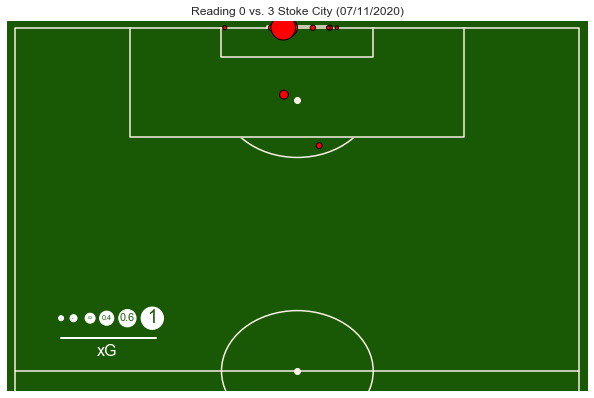

In [73]:
# Plotting Shots

## Define DataFrame
df_shots = df_events[df_events['possession_team.name'] == 'Stoke City']

## Draw the pitch
draw_pitch("#195905","#faf0e6","vertical","half")

## Define zo
zo = 12

## X and Y coordinates
x = df_shots['shot.end_location_xM'].tolist()
y = df_shots['shot.end_location_yM'].tolist()
y1 = [68 - i for i in y]


## Add Z variable for xG
z = df_shots['shot.statsbomb_xg_s'].tolist()
z1 = [500 * i for i in z] # This is to scale the "xG" values for plotting


## Add small legend in the bottom corner
mSize = [0.05,0.10,0.2,0.4,0.6,1]
mSizeS = [500 * i for i in mSize]
mx = [5.5,7,9,11,13.5,16.5]
my = [60,60,60,60,60,60]

plt.text(11,55,"xG", color="white", ha="center",va="center", zorder=zo, fontsize=16)
plt.scatter(y1,x,s=z1, c="red",edgecolors="k",zorder=zo)
plt.scatter(mx,my,s=mSizeS,facecolors="white", edgecolor="white",zorder=zo)
plt.plot([5.5,17], [57,57],color="white",lw=2,zorder=zo)

i = 0

for i in range(len(mx)):
    plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color="#195905", zorder=zo,ha="center", va="center")

    
## Title
plt.title('Reading 0 vs. 3 Stoke City (07/11/2020)')

## Show plot
plt.show()

### <a id='#section5.2'>5.2. Aggregation of Event Data for Stats</a>

In [ ]:
# Create stats aggregated table like that seen in on FBref here

## <a id='#section6'>6. Summary</a>
This notebook engineers scraped [StatsBomb](https://statsbomb.com/) data using [pandas](http://pandas.pydata.org/).

## <a id='#section7'>7. Next Steps</a>
...

## <a id='#section8'>8. References</a>

#### Data
*    [StatsBomb](https://statsbomb.com/) for the data to scrape

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)